# 🧪 GenAI Chemical Evaluation Framework

## Overview
This notebook contains a pipeline for benchmarking Generative AI models on chemical structure generation. Unlike standard metrics that only measure validity, this project implements a **stratified complexity assessment** and a **granular diagnosis engine**.

We aim to answer not just *if* a model fails, but *why* it fails (e.g., stereochemistry errors vs. hallucinations) and how these failures correlate with molecular complexity.

## 📊 Dataset & Stratification

We utilize the **[PharMolix/Vis-CheBI20](https://huggingface.co/datasets/PharMolix/Vis-CheBI20)** dataset as our ground truth.

### The Pipeline
1.  **Extraction:** We isolate SMILES strings from the source dataset.
2.  **Complexity Scoring:** We compute the **Synthetic Accessibility Score (`sa_score`)** for every molecule to quantify structural difficulty.
3.  **Binning & Sampling:**
    * Compounds are categorized into **Easy**, **Moderate**, and **Hard** tiers based on `sa_score`.
    * We generate a balanced evaluation set of **150 compounds** (50 per tier).

## 🧠 Diagnostic Methodology

We employ a custom evaluation algorithm (`get_smiles_metrics`) that moves beyond binary pass/fail checks. It uses **RDKit**, **Tanimoto Similarity**, and **InChI Layers** to classify predictions into specific error categories.

### Error Diagnosis Hierarchy

| Diagnosis Category | Description | Logic Used |
| :--- | :--- | :--- |
| **Perfect Match** | Prediction is identical to Ground Truth. | Canonical SMILES Match |
| **Stereochemistry Error** | Correct graph connectivity, wrong 3D orientation. | InChI Key Layer (Connectivity match, Stereo mismatch) |
| **Tautomer/Protonation** | Correct skeleton, wrong H-count/charge. | InChI Key Layer |
| **Constitutional Isomer** | Same atoms/formula, different connectivity. | Molecular Formula Match |
| **Fragment / Extra Atoms** | Prediction is a substructure (or superstructure) of Truth. | Substructure Match |
| **Scaffold Mismatch** | Prediction is chemically valid but structurally distinct. | Tanimoto Similarity < 0.4 |
| **Hallucination** | Output is not a valid chemical structure. | RDKit Parsing |

## 📈 Scoring
* **Validity:** Boolean check for chemical syntax.
* **Similarity:** Morgan Fingerprints (Radius 2, 2048 bits) with Tanimoto coefficient.

# Libraries

In [ ]:
# Install missing library rdkit
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 47.5 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import snapshot_download
import json
from pathlib import Path
from datasets import Dataset, Image
import os
import pandas as pd
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem,Descriptors, rdMolDescriptors
from rdkit.Contrib.SA_Score import sascorer
import warnings

# Data Preparation

## Download dataset

In [ ]:
# 1. Download the entire dataset repo locally
root = Path(
    snapshot_download(
        repo_id="PharMolix/Vis-CheBI20",
        repo_type="dataset"
    )
)

train_json = root / "train.json"
test_json  = root / "test.json"

# 2. Load JSON
with open(test_json, "r", encoding="utf-8") as f:
    data = json.load(f)

# Inspect one example to see actual keys:
print(data[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/739 [00:00<?, ?B/s]

train.json:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

imgs/train.zip:   0%|          | 0.00/8.00G [00:00<?, ?B/s]

imgs/test.zip:   0%|          | 0.00/983M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

{'images': ['imgs/test/000000.png'], 'messages': [{'role': 'user', 'content': 'What is the IUPAC of the molecule?'}, {'role': 'assistant', 'content': 'The IUPAC is methyl (2Z)-2-[(8S,9S,10R,13S,14S)-10,13-dimethyl-3,11-dioxo-1,2,6,7,8,9,12,14,15,16-decahydrocyclopenta[a]phenanthren-17-ylidene]acetate.'}], 'task_name': 'trans_iupac', 'dataset_name': 'vis_chebi20'}


## Preprocessing

In this step we restructure the dataset into 3 columns:


*   `image_id`: Path to the PNG image (e.g., "images/12345.png" – images are RDKit-generated diagrams in PNG format).
*    `IUPAC`: The ground-truth IUPAC name (chemist-readable systematic name).
* `Smiles`: Machine-readable molecular representation. Useful to compute the complexity of the chemical compound.



In [ ]:
combined_data = {}

for entry in data:
    image_id = None
    iupac_val = None
    smiles_val = None

    # Extract image_id from the first image path
    if 'images' in entry and entry['images'] and isinstance(entry['images'], list):
        image_path = entry['images'][0]
        image_id = os.path.splitext(os.path.basename(image_path))[0]

    if image_id is None:
        continue # Skip entries without a valid image_id

    # Initialize entry in combined_data if not already present
    if image_id not in combined_data:
        combined_data[image_id] = {
            'image_id': image_id,
            'IUPAC': None,
            'Smiles': None
        }

    # Extract IUPAC and Smiles from messages based on task_name
    if 'messages' in entry and isinstance(entry['messages'], list):
        if entry.get('task_name') == 'trans_iupac':
            for message in entry['messages']:
                if message.get('role') == 'assistant' and message.get('content'):
                    content = message['content']
                    if content.startswith('The IUPAC is '):
                        iupac_val = content[len('The IUPAC is '):].strip()
                        combined_data[image_id]['IUPAC'] = iupac_val.rstrip('. ')
                    break # Assuming only one assistant response for IUPAC
        elif entry.get('task_name') == 'trans_smiles':
            for message in entry['messages']:
                if message.get('role') == 'assistant' and message.get('content'):
                    content = message['content']
                    if content.startswith('The SMILES is '):
                        smiles_val = content[len('The SMILES is '):].strip()
                        combined_data[image_id]['Smiles'] = smiles_val.rstrip('. ')
                    break # Assuming only one assistant response for Smiles

# Convert the dictionary values (which are the consolidated records) into a list
processed_data_list = list(combined_data.values())

# Create the new Dataset
custom_ds = Dataset.from_list(processed_data_list)
# Transfrom the Dataset into pandas
pandas_df = custom_ds.to_pandas()
# Filter missing IUPAC and Smiles
df = pandas_df.dropna(subset=['IUPAC', 'Smiles'])


display(df.head())

print(f"Shape of the final DataFrame: {df.shape}")

,image_id,IUPAC,Smiles
0,000000,"methyl (2Z)-2-[(8S,9S,10R,13S,14S)-10,13-dimet...",C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2C(=O)C[C@]\\...
1,000001,"N-[(2S,3R,4R,5S,6R)-2-[(2R,3S,4R,5R,6R)-5-acet...",C[C@H]1[C@H]([C@H]([C@@H]([C@@H](O1)OC[C@@H]2[...
2,000002,"[(E)-[2-(4-methoxy-1H-indol-3-yl)-1-[(2S,3R,4S...",COC1=CC=CC2=C1C(=CN2)C/C(=N/OS(=O)(=O)[O-])/S[...
3,000003,4-[4-(4-chlorophenyl)-4-hydroxypiperidin-1-yl]...,CN(C)C(=O)C(CCN1CCC(CC1)(C2=CC=C(C=C2)Cl)O)(C3...
4,000004,4-[3-[(4-amino-2-methylpyrimidin-5-yl)methyl]-...,CC1=C(SC(=[N+]1CC2=CN=C(N=C2N)C)C(CCC(=O)O)O)C...


Shape of the final DataFrame: (2680, 3)


## Compute complexity
We compute the molecules complexity based on SMILES. The goal here is to separate the molecules into different level of complexities to assess the GenAI more thoroughly on different level of complexity levels.

[06:39:43] WARNING: not removing hydrogen atom without neighbors
/tmp/ipython-input-2648276034.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['complexity_score'] = df.apply(compute_complexity, axis=1)


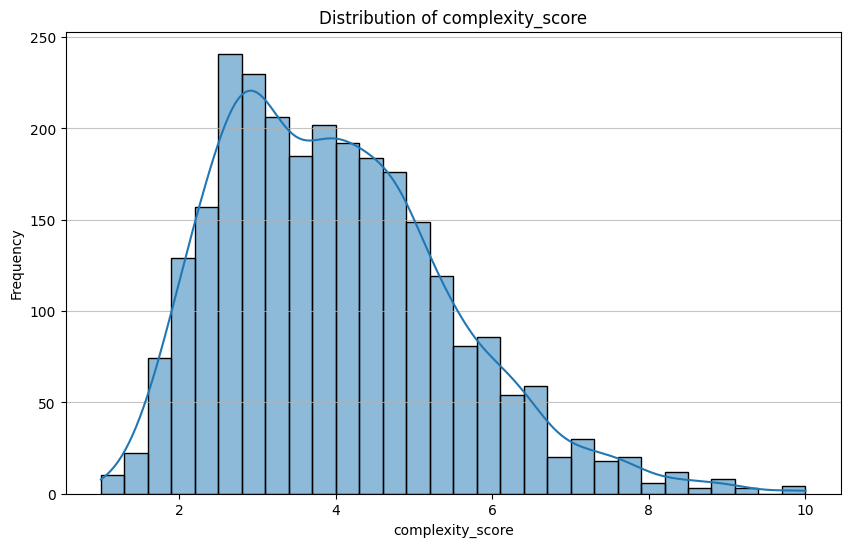

In [ ]:
def mol_from_smiles(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    return mol

def compute_complexity(row):
    smiles = row['Smiles']
    mol = mol_from_smiles(smiles)
    if mol is None:
        return None
    return sascorer.calculateScore(mol)

# Append complexity_score
df['complexity_score'] = df.apply(compute_complexity, axis=1)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of complexity_score
plt.figure(figsize=(10, 6))
sns.histplot(df['complexity_score'].dropna(), bins=30, kde=True)
plt.title('Distribution of complexity_score')
plt.xlabel('complexity_score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The levels we propose are:
* `easy`      score<3
* `moderate`  3<score<6
* `hard`      6<score

In [ ]:
# Define the boundaries for complexity levels
def get_complexity_level(score):
    if score is None: # Handle cases where complexity_score might be None
        return 'Undefined'
    elif score < 3:
        return 'easy'
    elif 3 <= score < 6:
        return 'moderate'
    else:
        return 'hard'

# Apply the function to create a new 'complexity_level' column in df_copy
df['complexity_level'] = df['complexity_score'].apply(get_complexity_level)

# Compute the count of molecules in each complexity group
complexity_counts = df['complexity_level'].value_counts()

print("Number of molecules in each complexity group:")
display(complexity_counts)

Number of molecules in each complexity group:


/tmp/ipython-input-2641833471.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['complexity_level'] = df['complexity_score'].apply(get_complexity_level)


,count
complexity_level,
moderate,1620
easy,789
hard,271


## Creating Samples



In [ ]:
import numpy as np


all_complexity_dfs = {}
complexity_levels = ['easy', 'moderate', 'hard']
sample_size = 50

for level in complexity_levels:
    # Filter for the current complexity level
    level_df = df[df['complexity_level'] == level]

    # Check if there are enough samples, if not, take all available
    current_sample_size = min(sample_size, len(level_df))

    # Randomly sample 'sample_size' rows
    sampled_df = level_df.sample(n=current_sample_size, random_state=42) # Using random_state for reproducibility

    # Select and rename columns
    final_df = sampled_df[['image_id', 'Smiles']].rename(columns={'image_id': 'id', 'Smiles': 'actual'})

    all_complexity_dfs[level + '_df'] = final_df
    print(f"Created {level}_df with {len(final_df)} samples.")
    display(final_df.head())


# Sort by id to ease the experiment
all_complexity_dfs['easy_df'] = all_complexity_dfs['easy_df'].sort_values(by='id').reset_index(drop=True)
all_complexity_dfs['moderate_df'] = all_complexity_dfs['moderate_df'].sort_values(by='id').reset_index(drop=True)
all_complexity_dfs['hard_df'] = all_complexity_dfs['hard_df'].sort_values(by='id').reset_index(drop=True)

# Assign to individual dataframes for easy access
easy_df = all_complexity_dfs['easy_df']
moderate_df = all_complexity_dfs['moderate_df']
hard_df = all_complexity_dfs['hard_df']

Created easy_df with 50 samples.


,id,actual
1725,001737,CN(C)CCCN1C2=CC=CC=C2CCC3=C1C=C(C=C3)Cl
121,000122,CC1=CC=C(C=C1)C(=O)OC2=C(C=C(C=C2)C(CNC(C)(C)C...
659,000663,C[C@H](CCCCCCCCCCC[C@H](CC(=O)O)O)O
629,000633,CCCCCCCCCCCC(=O)[O-]
747,000752,CC1=CC(=C(C=C1C2CCNCC2)OC(C)C)NC3=NC=C(C(=N3)N...


Created moderate_df with 50 samples.


,id,actual
235,000237,CCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C...
790,000795,C1=C(C(=O)NC(=S)N1[C@H]2[C@@H]([C@@H]([C@H](O2...
2599,002614,COC1=C(C=C2C(=C1)NC3=C(C[C@]45CCO[C@H]4CCN6[C@...
924,000932,C(C/C=C\\C/C=C\\C/C=C\\C/C=C\\C/C=C\\CCO)CC(=O...
2624,002639,CC/C=C\\C[C@@H](/C=C/C=CC=CC=CC([C@H](CCCCCC(=...


Created hard_df with 50 samples.


,id,actual
358,000360,[OH-].[OH-].[Mg+2]
1405,001415,[C@@H]1([C@@H]([C@H]([C@@H]([C@H]([C@@H]1O)O)O...
1025,001033,C[C@H]1CC[C@]2([C@H]([C@H]3[C@@H](O2)C[C@@H]4[...
1486,001497,[Co]
2044,002057,C[NH2+]CCCC[NH3+]


# Export samples

In [ ]:
output_dir = Path("samples")
output_dir.mkdir(parents=True, exist_ok=True)

for level, df_to_export in all_complexity_dfs.items():
    filename = output_dir / f"{level.replace('_df', '')}_samples.txt"
    df_to_export.to_csv(filename, index=False, sep=',')
    print(f"Exported {len(df_to_export)} samples to {filename}")

Exported 50 samples to samples/easy_samples.txt
Exported 50 samples to samples/moderate_samples.txt
Exported 50 samples to samples/hard_samples.txt


The three different samples are used in combination with the images under [Vis-CheBI20](https://huggingface.co/datasets/PharMolix/Vis-CheBI20/blob/main/imgs/test.zip) to generate documents with different levels to be provided to the GenAI. The GenAI will then provide an output with its result to be evaluated.

# Generated predictions

We used the following prompt to generate the Smiles in batches of 10 images at the time due to UI limit. We used 3 different models GPT-5.1 Thinkig, Gemini-3 Pro Thinking, and Grok-4 Expert.

## Prompt
```
You are a chemoinformatics assistant.

In this message you receive:
A list of 10 IDs in the text of the message.
10 PNG images attached, where each filename is ID.png and ID matches one of the IDs in the list.

Your task:
For each ID, use its corresponding image (ID.png) to infer the molecule and generate a valid SMILES string. If unsure, give your best SMILES guess for each ID.

Output rules (VERY IMPORTANT):
1.  **Output Format:** You must enclose your entire response in a CSV code block (use ```csv at the start and ``` at the end).
2.  **Raw Data Only:** Inside the code block, do not include any Markdown links, hyperlinks, or URLs.
3.  **SMILES Syntax:** Treat characters strictly as chemical notation.
    - The character '=' is a double bond.
    - The character 'O' is Oxygen.
    - Do NOT interpret '=O' as a search query or URL parameter.
4.  **No Explanations:** Reply only with the 10 data lines. No header row, no introductory text, no "Here is the list".

Each line must be exactly in the format:
id,"Smiles"

Allowed characters in SMILES:
Letters: B C N O S P F I Cl Br H (and lower/upper case)
Digits: 0-9
Symbols: = # - + ( ) [ ] @ / \ . %

Example Output:
```csv
001206,"CCCCCCCC(=O)O"
001218,"CCCCCCCCCCCCCCCC(=O)O"

Ids:
```

## Output

For each model, we generate 3 different files, one for each level of complexity.

# Data analysis

Now we have the results, we can perform analysis.

First, we look at two main metrics:

*   `Precision`: compute the percentage of exact Smiles.
*   `Grade`: grade of how close the predictions are to the real Smiles using TanimotoSimilarity.



In [ ]:
output_dir = Path("output")

# List of files to process
files_to_load = [
    output_dir / "easy_grok.txt",
    output_dir / "easy_actual.txt",
    output_dir / "easy_gemini.txt",
    output_dir / "easy_gpt.txt",
]

# Dictionary to store the loaded DataFrames
easy_datasets = {}

for file_path in files_to_load:
    if file_path.exists():
        df_name = f"easy_{file_path.stem.split('_')[1]}_df" # e.g., easy_grok_df
        # Read the CSV, assuming no header and columns are 'id' and 'name'
        df = pd.read_csv(file_path, header=None, names=['id', 'name'], sep=',')
        easy_datasets[df_name] = df
        print(f"Loaded {file_path.name} into {df_name}:")
        display(df.head())
    else:
        print(f"Warning: File not found at {file_path}")

# Assign to individual dataframes for easy access
grok_df = easy_datasets.get('easy_grok_df')
actual_df = easy_datasets.get('easy_actual_df')
gemini_df = easy_datasets.get('easy_gemini_df')
gpt_df = easy_datasets.get('easy_gpt_df')

Loaded easy_grok.txt into easy_grok_df:


,id,name
0,71,Oc1ccc(cc1)c2coc3cc(O)cc(O)c3c2=O
1,122,O=c1nc2[nH]c(c3ccccc3)nc2[nH]c1=O
2,206,O=S(=O)(O)Oc1ccc(cc1)N+[O-]
3,229,O=S(=O)([O-])Oc1ccc(cc1)N+[O-]
4,255,CC1ccc(cc1)C(=O)Oc2cc(O)ccc2CNHC(C)C


Loaded easy_actual.txt into easy_actual_df:


,id,name
0,71,C1C(OC2=CC(=C(C=C2C1=O)O)O)C3=CC=C(C=C3)O
1,122,CC1=CC=C(C=C1)C(=O)OC2=C(C=C(C=C2)C(CNC(C)(C)C...
2,206,CC1=CN=C(C(=C1OC)C)CN2C=NC3=C2N=C(N=C3Cl)N
3,229,C1=CC=C(C=C1)C2=C(C(=O)NC3=CC=CC=C32)O
4,255,CN1C2=C(C3=C(C=C2)N=CC=C3)N=C1N


Loaded easy_gemini.txt into easy_gemini_df:


,id,name
0,71,Oc1ccc(cc1)C2CC(=O)c3c(O2)cc(O)c(O)c3
1,122,CC(C)(C)NCC(O)c1ccc(OC(=O)c2ccc(C)cc2)c(OC(=O)...
2,206,COc1c(C)cnc(Cn2cnc3c(N)nc(Cl)nc32)c1C
3,229,Oc1c(c2ccccc2)c2ccccc2[nH]c1=O
4,255,Cn1c(N)nc2c1cc3ncccc3c2


Loaded easy_gpt.txt into easy_gpt_df:


,id,name
0,71,O=C1CC(c2ccc(O)cc2)Oc3cc(O)cc(O)c31
1,122,CC(C)(C)NCC(O)c1cc(OC(=O)c2ccc(C)cc2)cc(OC(=O)...
2,206,COc1cc(C)nc(C)c1CNc2nc(Cl)c3ncnc3n2N
3,229,OC(C(c1ccccc1)C2=CC3=CC=CC=C3NC2=O)
4,255,CN1c2ncccc2c3ncc(N)nc13


In [ ]:
import pandas as pd
from pathlib import Path

output_dir = Path("output")

all_predictions_data = []
all_actual_data = []

# List all files in the output directory and process them
for file_path in output_dir.glob("*.txt"):
    filename_stem = file_path.stem  # e.g., 'easy_grok'
    parts = filename_stem.split('_')  # e.g., ['easy', 'grok']

    if len(parts) == 2:
        complexity = parts[0]
        source = parts[1]  # 'grok', 'gemini', 'gpt', or 'actual'

        if complexity not in ['easy', 'moderate', 'hard']:
            print(f"Skipping file with unknown complexity level: {file_path.name}")
            continue

        # Read the CSV, assuming no header and columns are 'id' and 'name'
        df = pd.read_csv(file_path, header=None, names=['id', 'name'], sep=',')

        if source == 'actual':
            df['complexity'] = complexity
            all_actual_data.append(df)
        elif source in ['grok', 'gemini', 'gpt']:
            df['model'] = source
            df['complexity'] = complexity
            all_predictions_data.append(df)
        else:
            print(f"Skipping file with unknown source type: {file_path.name}")
            continue
    else:
        print(f"Skipping malformed filename: {file_path.name}")

# Concatenate all collected DataFrames for predictions
if all_predictions_data:
    combined_predictions_df = pd.concat(all_predictions_data, ignore_index=True)
else:
    combined_predictions_df = pd.DataFrame(columns=['id', 'name', 'model', 'complexity'])

# Concatenate all collected DataFrames for actual values
if all_actual_data:
    combined_actual_df = pd.concat(all_actual_data, ignore_index=True)
else:
    combined_actual_df = pd.DataFrame(columns=['id', 'name', 'complexity'])

print("Combined Predictions DataFrame:")
display(combined_predictions_df.head())
print(f"Shape: {combined_predictions_df.shape}")

print("\nCombined Actual DataFrame:")
display(combined_actual_df.head())
print(f"Shape: {combined_actual_df.shape}")

Combined Predictions DataFrame:


,id,name,model,complexity
0,100,[OH-].[Mg+2].[OH-],grok,hard
1,150,[NH3+]CCCC[C]([NH3+])C(=O)[O-],grok,hard
2,247,C[N+](C)(C)CC(=O)[O-],grok,hard
3,263,CCCCO,grok,hard
4,283,C(=O)[O-],grok,hard


Shape: (450, 4)

Combined Actual DataFrame:


,id,name,complexity
0,36,C1=NC2=C(NC(=O)N=C2N1[C@H]3[C@@H]([C@@H]([C@H]...,moderate
1,49,C(CN)[C@H](C[C@@H](C(=O)O)N)O,moderate
2,50,CC(=CCC1=C2C(=C(C3=C1OC(C=C3)(C)C)OC)C(=C(C(=O...,moderate
3,117,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,moderate
4,213,C[C@H]1[C@@H](C[C@H]([C@@H](O1)O[C@H](C)CCCCCC...,moderate


Shape: (150, 3)


In [ ]:
def get_smiles_metrics(pred_smiles, true_smiles):
    """
    Scores predicted SMILES against ground truth with granular error diagnosis.
    """
    # 1. Parsing & Basic Sanitization
    try:
        mol_pred = Chem.MolFromSmiles(pred_smiles)
        # Sanitize to fix common AI hallucinations (like aromaticity errors)
        if mol_pred: Chem.SanitizeMol(mol_pred)
    except:
        mol_pred = None

    mol_true = Chem.MolFromSmiles(true_smiles) # Assume Ground Truth is valid

    score = 0.0
    diagnosis = "Unknown Error"

    # 2. Validity Checks
    if mol_pred is None:
        return 0.0, "Invalid SMILES Syntax"
    if mol_true is None:
        return 0.0, "Invalid Ground Truth"

    # 3. Exact Match (Canonical SMILES) - Fastest check
    canon_pred = Chem.MolToSmiles(mol_pred, isomericSmiles=True, canonical=True)
    canon_true = Chem.MolToSmiles(mol_true, isomericSmiles=True, canonical=True)

    if canon_pred == canon_true:
        return 1.0, "Perfect Match"

    # 4. Calculate Similarity (Tanimoto)
    # Using radius 2 (ECFP4) and 2048 bits is standard
    fp_pred = AllChem.GetMorganFingerprintAsBitVect(mol_pred, 2, nBits=2048, useChirality=True)
    fp_true = AllChem.GetMorganFingerprintAsBitVect(mol_true, 2, nBits=2048, useChirality=True)
    score = round(DataStructs.TanimotoSimilarity(fp_pred, fp_true), 4)

    # 5. Granular Diagnosis
    # We use InChI Layers to diagnose Tautomers/Stereo accurately
    try:
        inchi_pred = Chem.MolToInchi(mol_pred)
        inchi_true = Chem.MolToInchi(mol_true)
        # InChI Key: First block is connectivity, Second is stereo/tautomer, Third is charge
        key_pred = Chem.MolToInchiKey(mol_pred).split('-')
        key_true = Chem.MolToInchiKey(mol_true).split('-')
    except:
        # Fallback if InChI fails (rare)
        key_pred = ["A", "A", "A"]
        key_true = ["B", "B", "B"]

    # A. Check Connectivity (First block of InChIKey)
    if key_pred[0] == key_true[0]:
        # Connectivity is identical, so the graph is the same.
        # Check Stereochemistry
        if Chem.MolToSmiles(mol_pred, isomericSmiles=False) == Chem.MolToSmiles(mol_true, isomericSmiles=False):
             diagnosis = "Stereochemistry Error" # Same graph, wrong wedge/dash
        else:
             diagnosis = "Tautomer/Protonation Difference" # Same skeleton, different H-count/charge

    # B. Check Isomers (Different connectivity, same formula)
    elif rdMolDescriptors.CalcMolFormula(mol_pred) == rdMolDescriptors.CalcMolFormula(mol_true):
        diagnosis = "Constitutional Isomer (Wrong Connectivity)"

    # C. Substructure Checks
    elif mol_true.GetNumAtoms() > mol_pred.GetNumAtoms() and mol_true.HasSubstructMatch(mol_pred):
        diagnosis = "Prediction is a Fragment (Missing Atoms)"
    elif mol_pred.GetNumAtoms() > mol_true.GetNumAtoms() and mol_pred.HasSubstructMatch(mol_true):
        diagnosis = "Prediction has Extra Atoms"

    # D. Similarity Thresholds
    elif score >= 0.8: # Adjusted threshold for "Very Close"
        diagnosis = "High Similarity Scaffold"
    elif score >= 0.4:
        diagnosis = "Scaffold Mismatch"
    else:
        diagnosis = "Hallucination / Different Molecule"

    return score, diagnosis

In [ ]:
warnings.filterwarnings('ignore')
RDLogger.DisableLog('rdApp.*')

# Merge predictions with actual values for scoring
# We merge on 'id' and 'complexity' to correctly match actuals to predictions
merged_df = pd.merge(
    combined_predictions_df,
    combined_actual_df,
    on=['id', 'complexity'],
    suffixes=('_pred', '_actual')
)

# Apply the scoring and diagnosis function from the previously defined `get_smiles_metrics`
# The function is assumed to be defined in a previous cell (CNmYGPaDwAy4)
merged_df[['score', 'diagnose']] = merged_df.apply(
    lambda row: get_smiles_metrics(row['name_pred'], row['name_actual']), axis=1, result_type='expand'
)

print("Merged DataFrame with Scores and Diagnoses (first 5 rows):")
display(merged_df.head())
print(f"Total entries: {merged_df.shape[0]}")

# Group by model and complexity to calculate statistics
analysis_results = []

for (model, complexity), group_df in merged_df.groupby(['model', 'complexity']):
    avg_score = group_df['score'].mean()
    perfect_score_pct = (group_df['score'] == 1.0).sum() / len(group_df) * 100

    diagnosis_counts = group_df['diagnose'].value_counts().to_dict()
    diagnosis_percentages = group_df['diagnose'].value_counts(normalize=True).mul(100).to_dict()

    analysis_results.append({
        'model': model,
        'complexity': complexity,
        'average_score': avg_score,
        'perfect_score_percentage': perfect_score_pct,
        'diagnosis_counts': diagnosis_counts,
        'diagnosis_percentages': diagnosis_percentages
    })

# Define a custom sorting key for complexity levels
complexity_order = {'easy': 0, 'moderate': 1, 'hard': 2}

# Sort analysis_results by complexity then by model
sorted_analysis_results = sorted(analysis_results, key=lambda x: (complexity_order[x['complexity']], x['model']))

# Display results for each model and complexity level
for result in sorted_analysis_results:
    print(f"\n--- Analysis for Model: {result['model']}, Complexity: {result['complexity']} ---")
    print(f"Average Score: {result['average_score']:.4f}")
    print(f"Percentage of Perfect Scores (1.0): {result['perfect_score_percentage']:.2f}%")

    print("\nDiagnosis Counts:")
    # Sort for consistent output
    for diag, count in sorted(result['diagnosis_counts'].items()):
        print(f"  - {diag}: {count}")

    print("\nDiagnosis Percentages:")
    # Sort for consistent output
    for diag, pct in sorted(result['diagnosis_percentages'].items()):
        print(f"  - {diag}: {pct:.2f}%")

Merged DataFrame with Scores and Diagnoses (first 5 rows):


,id,name_pred,model,complexity,name_actual,score,diagnose
0,100,[OH-].[Mg+2].[OH-],grok,hard,CCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1[C@@H]([...,0.0000,Hallucination / Different Molecule
1,150,[NH3+]CCCC[C]([NH3+])C(=O)[O-],grok,hard,C1[C@@H](N=C(N[C@H]1O)N)[C@H]2C(=O)NC[C@@H](C(...,0.0500,Hallucination / Different Molecule
2,247,C[N+](C)(C)CC(=O)[O-],grok,hard,CC(=CCC1=C2C(=C(C3=C1O[C@@]45[C@@H]6C(=O)[C@@H...,0.0617,Hallucination / Different Molecule
3,263,CCCCO,grok,hard,C[C@H]1[C@@H](C[C@H]([C@@H](O1)OCCCCCCC/C=C/C(...,0.0342,Prediction is a Fragment (Missing Atoms)
4,283,C(=O)[O-],grok,hard,C[C@H](CCC(=O)SCCNC(=O)CCNC(=O)[C@@H](C(C)(C)C...,0.0164,Hallucination / Different Molecule


Total entries: 450

--- Analysis for Model: gemini, Complexity: easy ---
Average Score: 0.8005
Percentage of Perfect Scores (1.0): 54.00%

Diagnosis Counts:
  - Constitutional Isomer (Wrong Connectivity): 5
  - High Similarity Scaffold: 1
  - Invalid SMILES Syntax: 3
  - Perfect Match: 25
  - Prediction is a Fragment (Missing Atoms): 3
  - Scaffold Mismatch: 4
  - Stereochemistry Error: 9

Diagnosis Percentages:
  - Constitutional Isomer (Wrong Connectivity): 10.00%
  - High Similarity Scaffold: 2.00%
  - Invalid SMILES Syntax: 6.00%
  - Perfect Match: 50.00%
  - Prediction is a Fragment (Missing Atoms): 6.00%
  - Scaffold Mismatch: 8.00%
  - Stereochemistry Error: 18.00%

--- Analysis for Model: gpt, Complexity: easy ---
Average Score: 0.5318
Percentage of Perfect Scores (1.0): 20.00%

Diagnosis Counts:
  - Constitutional Isomer (Wrong Connectivity): 9
  - Hallucination / Different Molecule: 10
  - High Similarity Scaffold: 2
  - Invalid SMILES Syntax: 7
  - Perfect Match: 8
  - Predi

## Precision analysis

We analyzed the perfect scores per complexity level for each of the models.

### Precision per complexity

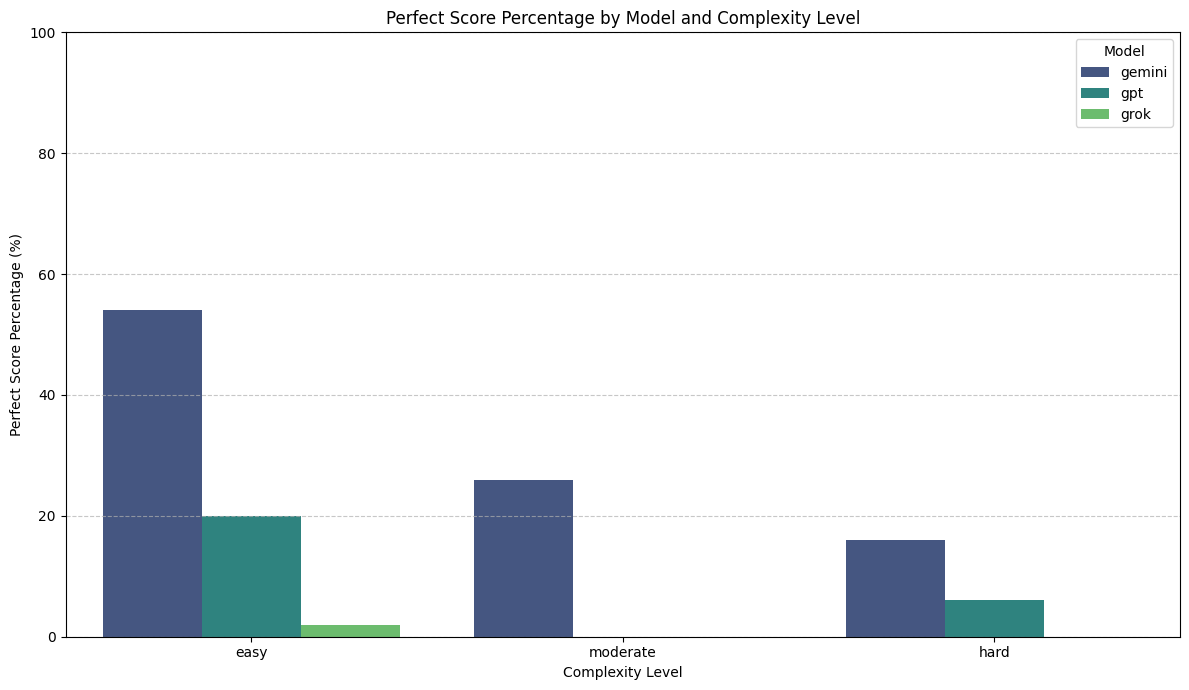

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert analysis_results to a DataFrame for easier plotting
results_df = pd.DataFrame(sorted_analysis_results)

# Filter for the relevant columns for precision analysis
precision_df = results_df[['model', 'complexity', 'perfect_score_percentage']]

# Define the order for complexity levels
complexity_order = ['easy', 'moderate', 'hard']
precision_df['complexity'] = pd.Categorical(precision_df['complexity'], categories=complexity_order, ordered=True)

# Sort the DataFrame for consistent plotting order
precision_df = precision_df.sort_values(by=['complexity', 'model'])

plt.figure(figsize=(12, 7))
sns.barplot(
    data=precision_df,
    x='complexity',
    y='perfect_score_percentage',
    hue='model',
    palette='viridis'
)

plt.title('Perfect Score Percentage by Model and Complexity Level')
plt.xlabel('Complexity Level')
plt.ylabel('Perfect Score Percentage (%)')
plt.ylim(0, 100) # Percentage is from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

### Precision per model

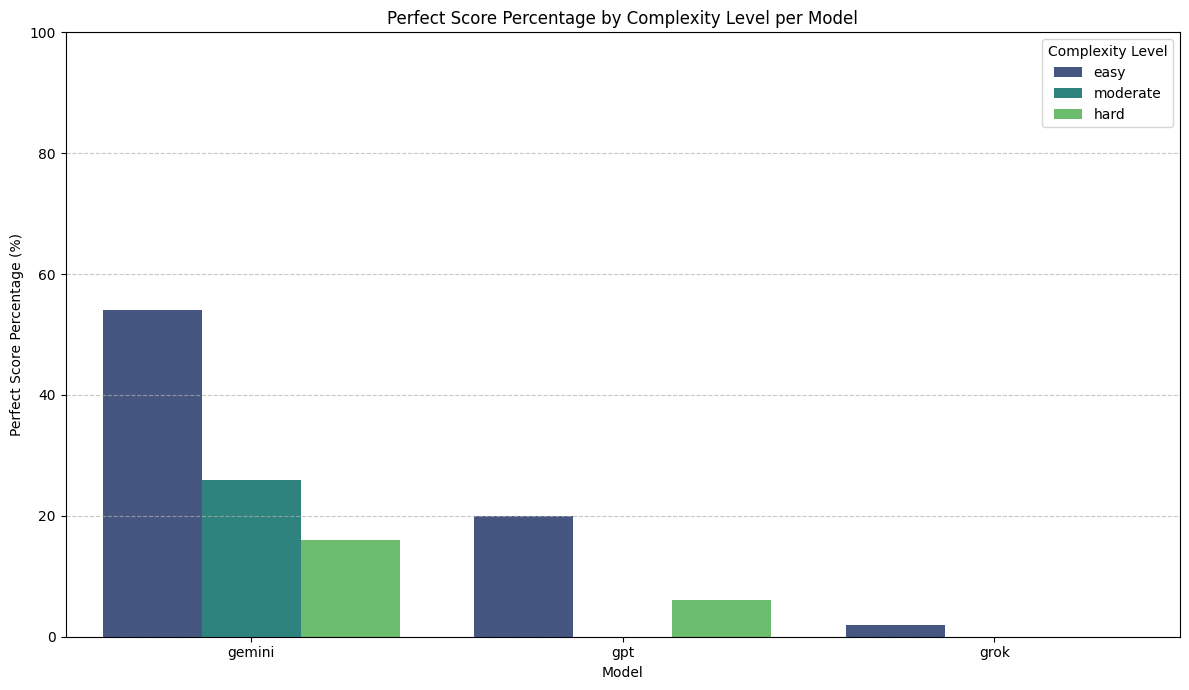

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df and precision_df from the previous cell are available
# If not, recreate them:
# results_df = pd.DataFrame(sorted_analysis_results)
# precision_df = results_df[['model', 'complexity', 'perfect_score_percentage']]
# complexity_order = ['easy', 'moderate', 'hard']
# precision_df['complexity'] = pd.Categorical(precision_df['complexity'], categories=complexity_order, ordered=True)
# precision_df = precision_df.sort_values(by=['model', 'complexity'])

plt.figure(figsize=(12, 7))
sns.barplot(
    data=precision_df,
    x='model',
    y='perfect_score_percentage',
    hue='complexity',
    palette='viridis'
)

plt.title('Perfect Score Percentage by Complexity Level per Model')
plt.xlabel('Model')
plt.ylabel('Perfect Score Percentage (%)')
plt.ylim(0, 100) # Percentage is from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Complexity Level')
plt.tight_layout()
plt.show()

## Grade analysis

We analyzed the grades we provided through our algorithm, scoring the quality of the prediction per complexity level for each of the models.

### Grade per complexity

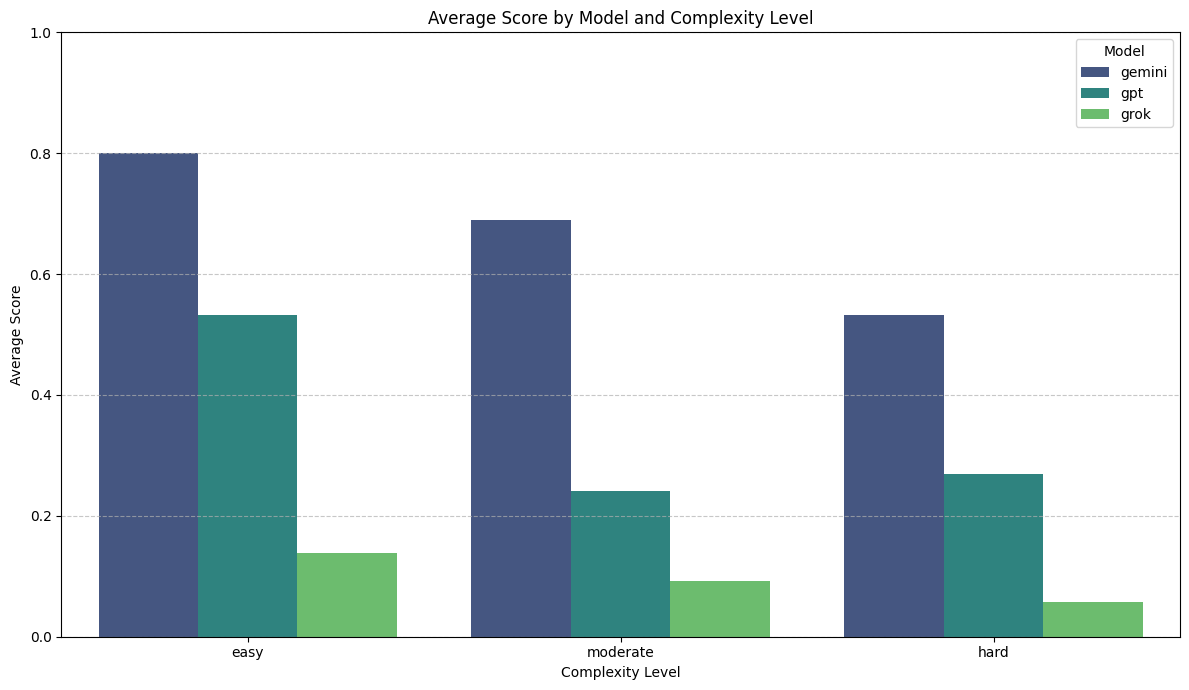

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert analysis_results to a DataFrame for easier plotting (if not already done)
# Assuming results_df is available from previous executions
if 'results_df' not in locals():
    results_df = pd.DataFrame(sorted_analysis_results)

# Filter for the relevant columns for average score analysis
score_df_complexity_grouped = results_df[['model', 'complexity', 'average_score']]

# Define the order for complexity levels
complexity_order = ['easy', 'moderate', 'hard']
score_df_complexity_grouped['complexity'] = pd.Categorical(score_df_complexity_grouped['complexity'], categories=complexity_order, ordered=True)

# Sort the DataFrame for consistent plotting order
score_df_complexity_grouped = score_df_complexity_grouped.sort_values(by=['complexity', 'model'])

plt.figure(figsize=(12, 7))
sns.barplot(
    data=score_df_complexity_grouped,
    x='complexity',
    y='average_score',
    hue='model',
    palette='viridis'
)

plt.title('Average Score by Model and Complexity Level')
plt.xlabel('Complexity Level')
plt.ylabel('Average Score')
plt.ylim(0, 1.0) # Scores are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

### Grade per model

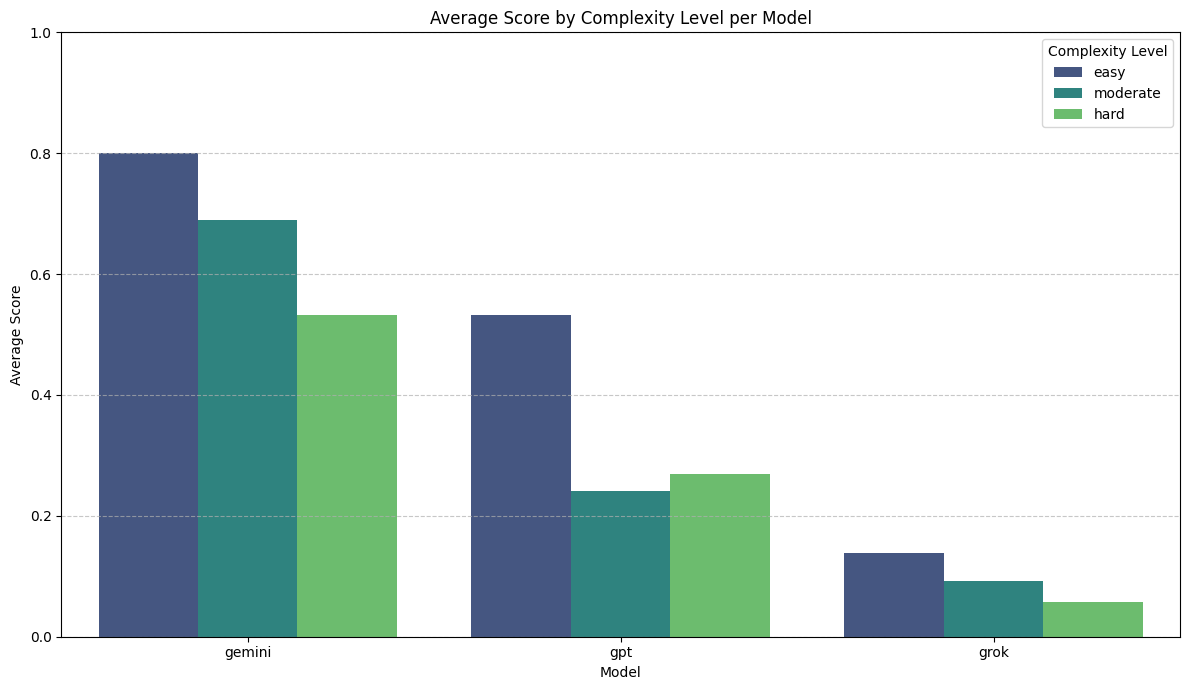

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert analysis_results to a DataFrame for easier plotting (if not already done)
# Assuming results_df is available from previous executions
if 'results_df' not in locals():
    results_df = pd.DataFrame(sorted_analysis_results)

# Filter for the relevant columns for average score analysis
score_df_model_grouped = results_df[['model', 'complexity', 'average_score']]

# Define the order for complexity levels
complexity_order = ['easy', 'moderate', 'hard']
score_df_model_grouped['complexity'] = pd.Categorical(score_df_model_grouped['complexity'], categories=complexity_order, ordered=True)

# Sort the DataFrame for consistent plotting order
score_df_model_grouped = score_df_model_grouped.sort_values(by=['model', 'complexity'])

plt.figure(figsize=(12, 7))
sns.barplot(
    data=score_df_model_grouped,
    x='model',
    y='average_score',
    hue='complexity',
    palette='viridis'
)

plt.title('Average Score by Complexity Level per Model')
plt.xlabel('Model')
plt.ylabel('Average Score')
plt.ylim(0, 1.0) # Scores are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Complexity Level')
plt.tight_layout()
plt.show()

## Diagnosis analysis

We analyzed the diagnosis given by the automated algorithm of root causing the predictions given by the models.

### Diagnosis per complexity


--- Diagnosis Analysis per Complexity Level ---


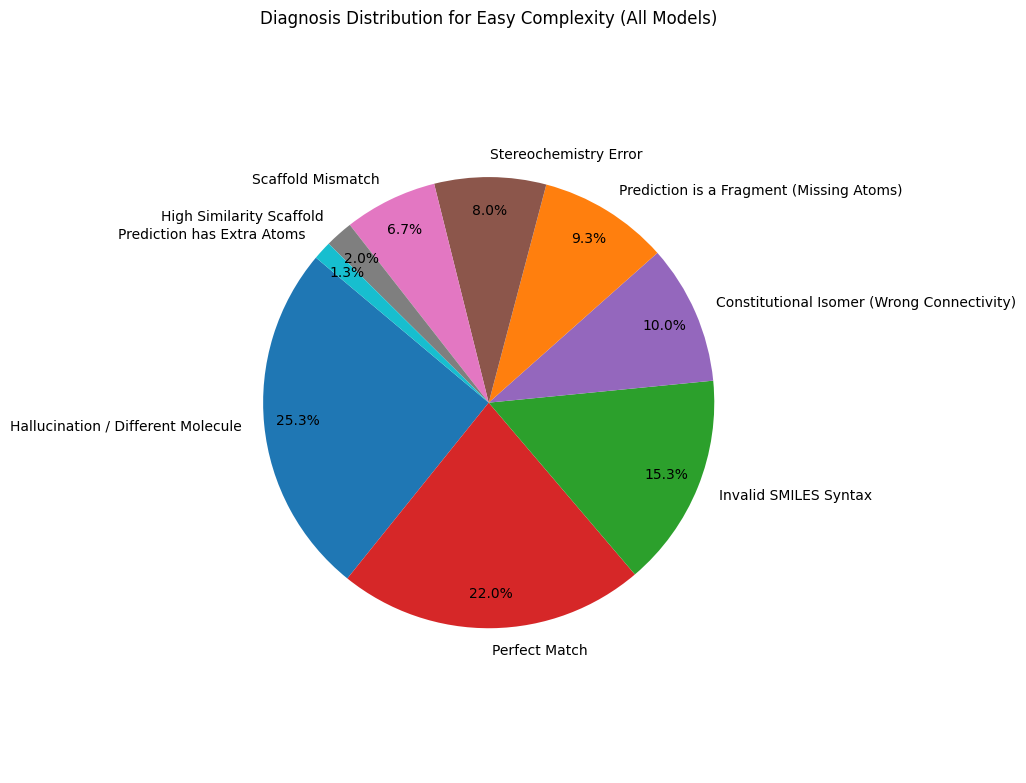

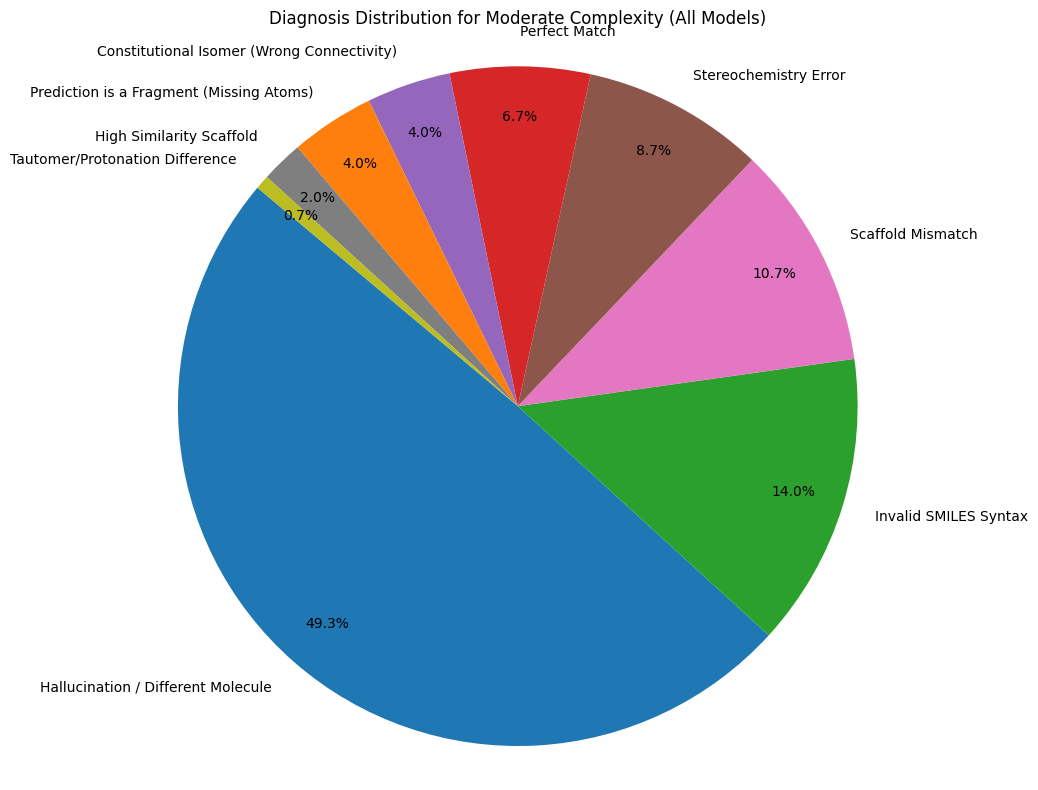

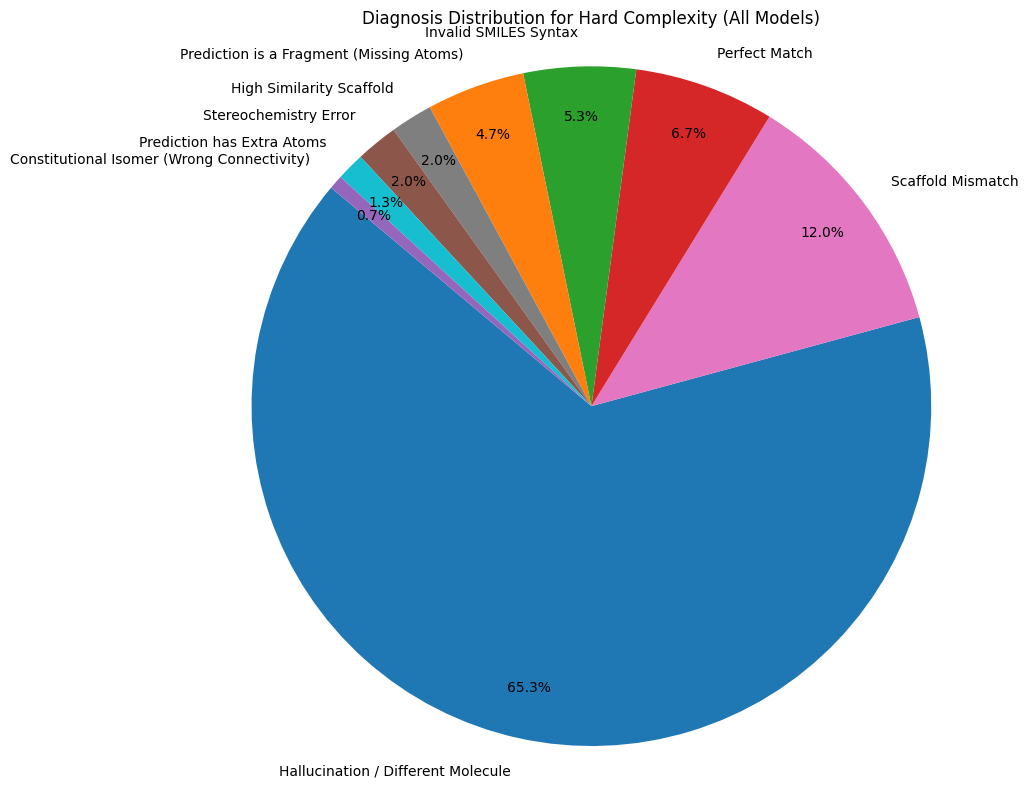

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is available from previous cells

# Get all unique diagnoses across the entire merged_df for consistent coloring
all_diagnoses = merged_df['diagnose'].unique()
num_diagnoses = len(all_diagnoses)
palette = sns.color_palette("tab10", num_diagnoses) # Or any other suitable palette
diagnosis_color_map = {diag: palette[i] for i, diag in enumerate(all_diagnoses)}

# Diagnosis per complexity
print("\n--- Diagnosis Analysis per Complexity Level ---")
complexity_levels = ['easy', 'moderate', 'hard']

for level in complexity_levels:
    # Filter data for the current complexity level
    df_level = merged_df[merged_df['complexity'] == level]

    # Get value counts of diagnoses for this level
    diagnosis_counts = df_level['diagnose'].value_counts()

    if not diagnosis_counts.empty:
        plt.figure(figsize=(10, 8))
        # Ensure colors are consistent using the global map
        colors = [diagnosis_color_map[label] for label in diagnosis_counts.index]
        plt.pie(
            diagnosis_counts,
            labels=diagnosis_counts.index,
            autopct='%1.1f%%',
            startangle=140,
            pctdistance=0.85, # Distance of percentage text from center
            colors=colors
        )
        plt.title(f'Diagnosis Distribution for {level.capitalize()} Complexity (All Models)')
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.tight_layout()
        plt.show()
    else:
        print(f"No diagnosis data for {level} complexity.")

### Diagnosis per model


--- Diagnosis Analysis per Model ---


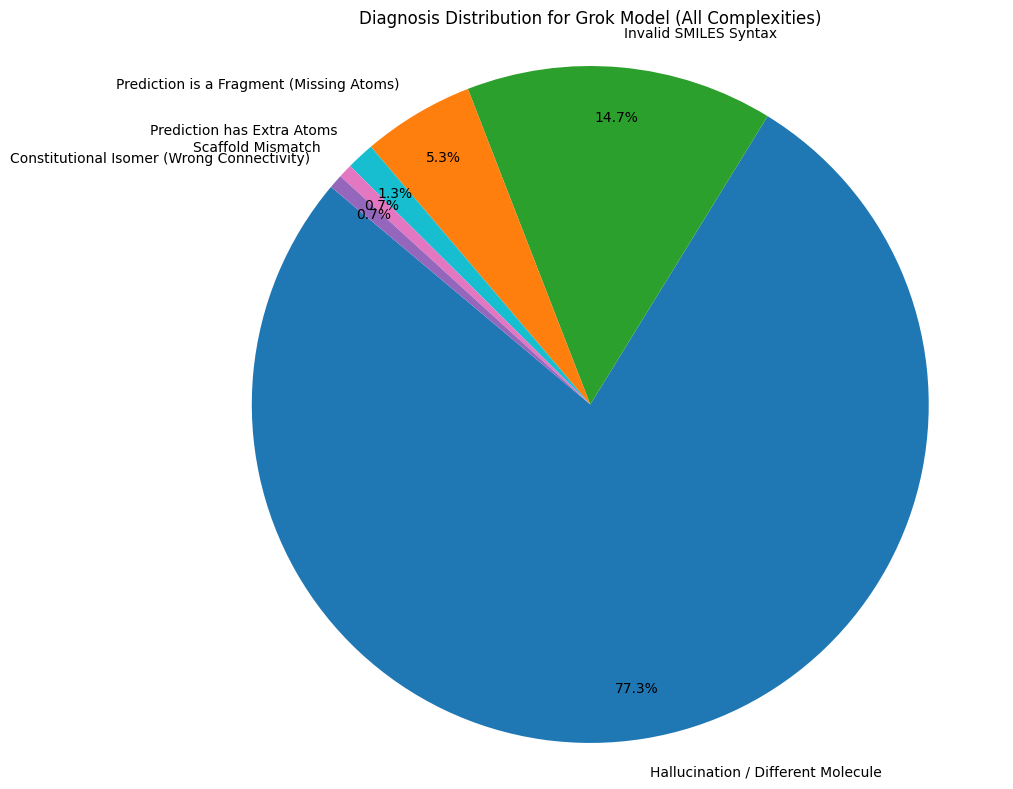

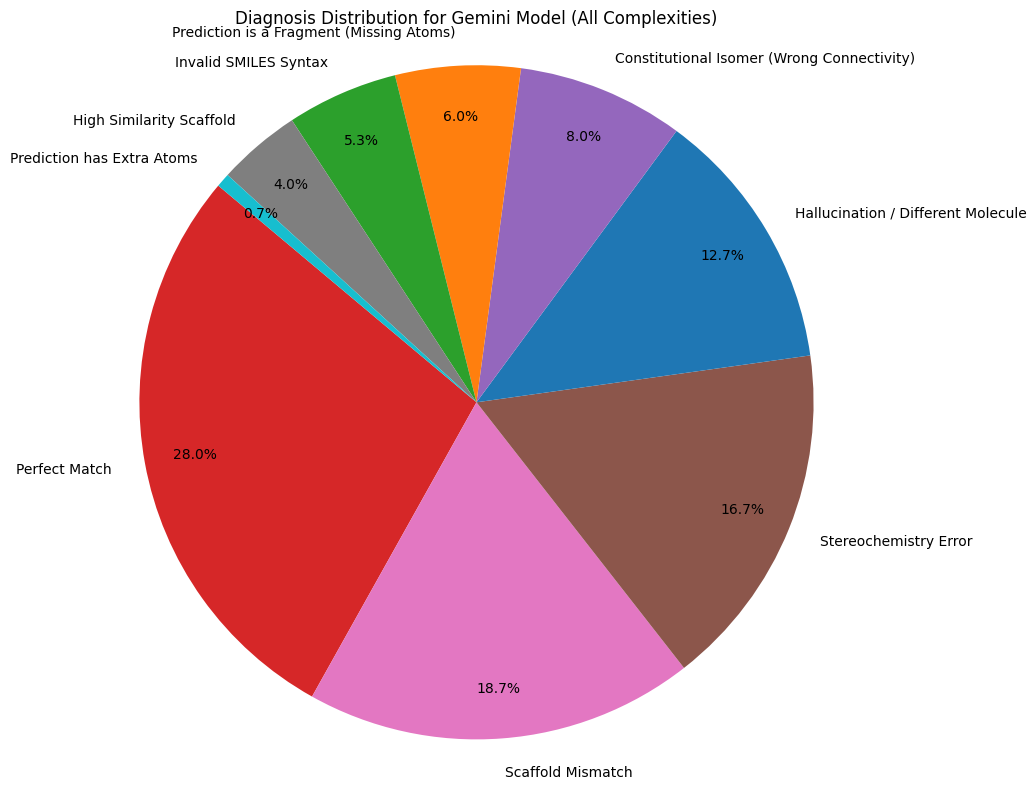

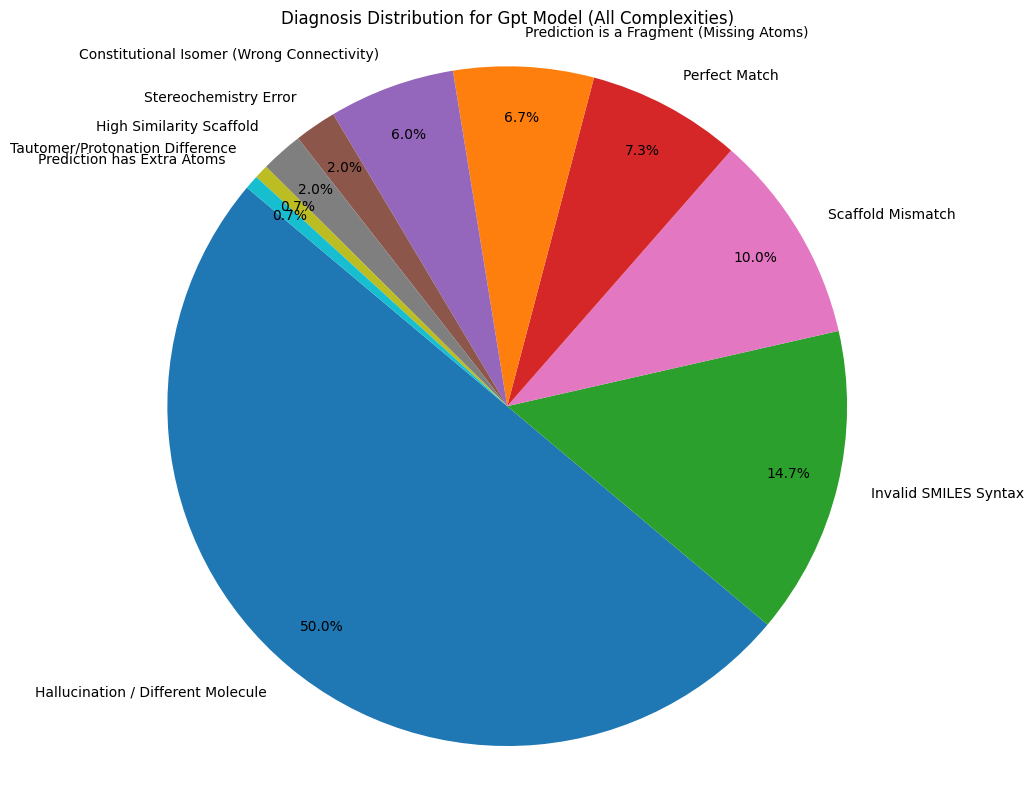

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df and diagnosis_color_map (from the previous cell) are available

# Diagnosis per model
print("\n--- Diagnosis Analysis per Model ---")
models = merged_df['model'].unique()

for model_name in models:
    # Filter data for the current model
    df_model = merged_df[merged_df['model'] == model_name]

    # Get value counts of diagnoses for this model
    diagnosis_counts = df_model['diagnose'].value_counts()

    if not diagnosis_counts.empty:
        plt.figure(figsize=(10, 8))
        # Ensure colors are consistent using the global map
        colors = [diagnosis_color_map[label] for label in diagnosis_counts.index]
        plt.pie(
            diagnosis_counts,
            labels=diagnosis_counts.index,
            autopct='%1.1f%%',
            startangle=140,
            pctdistance=0.85, # Distance of percentage text from center
            colors=colors
        )
        plt.title(f'Diagnosis Distribution for {model_name.capitalize()} Model (All Complexities)')
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.tight_layout()
        plt.show()
    else:
        print(f"No diagnosis data for {model_name} model.")

### Diagnosis per model and complexity level


--- Diagnosis Analysis per Model and Complexity ---


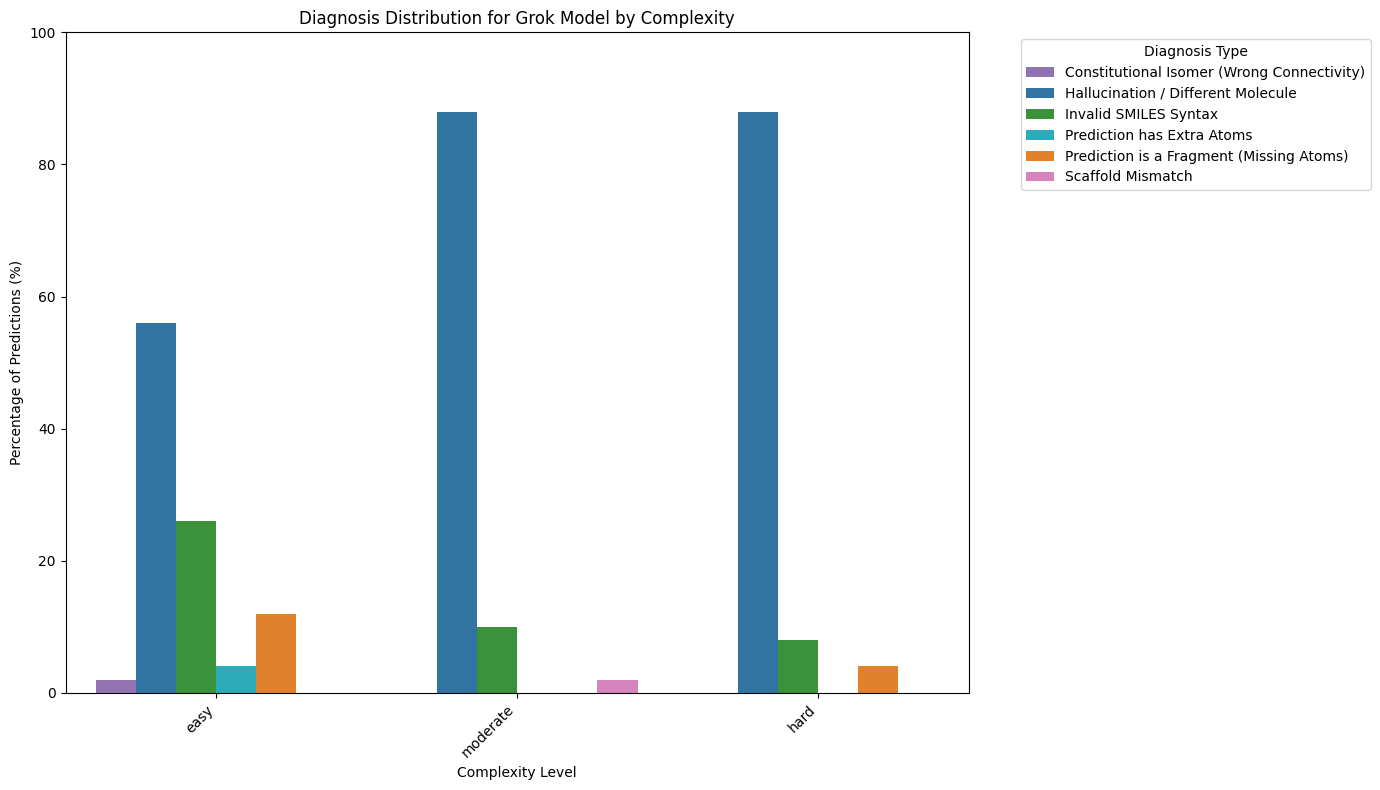

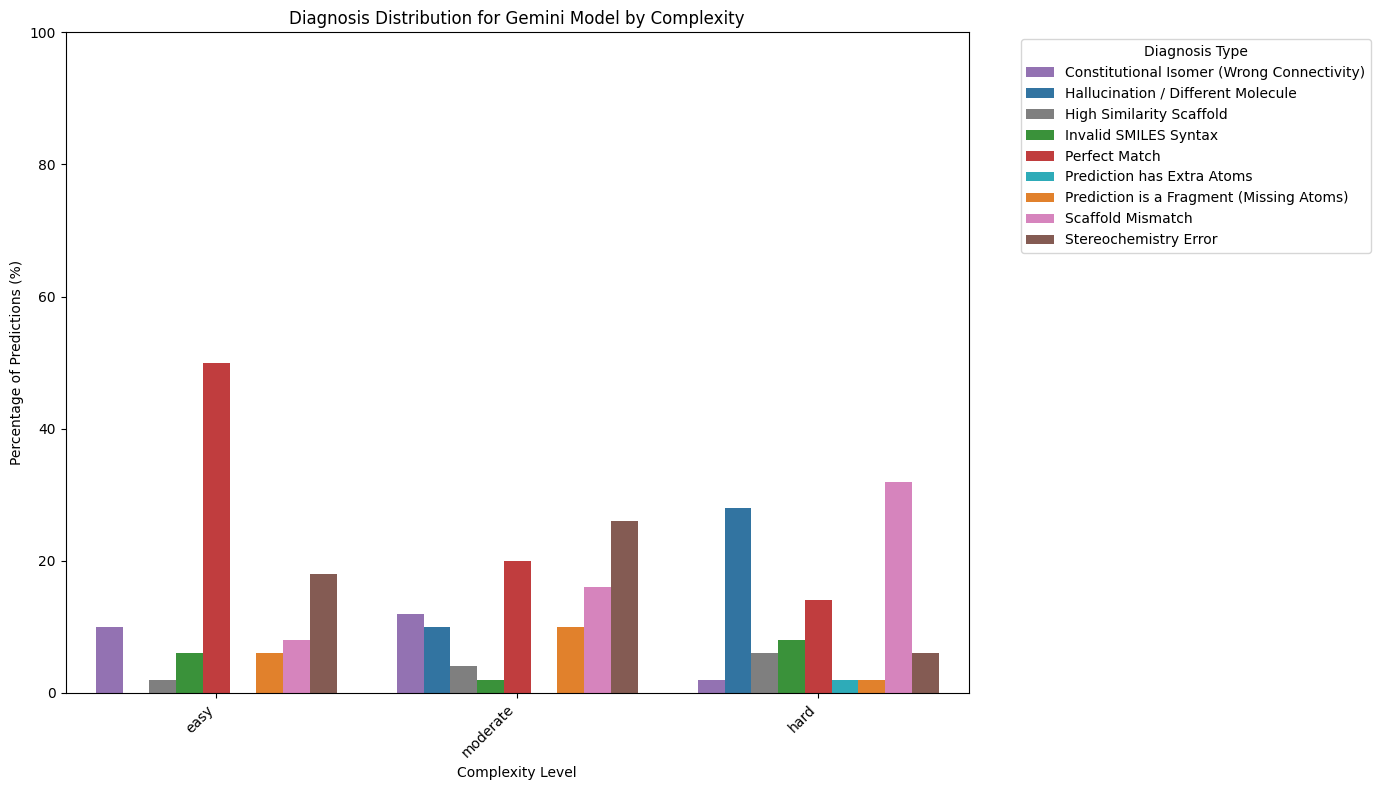

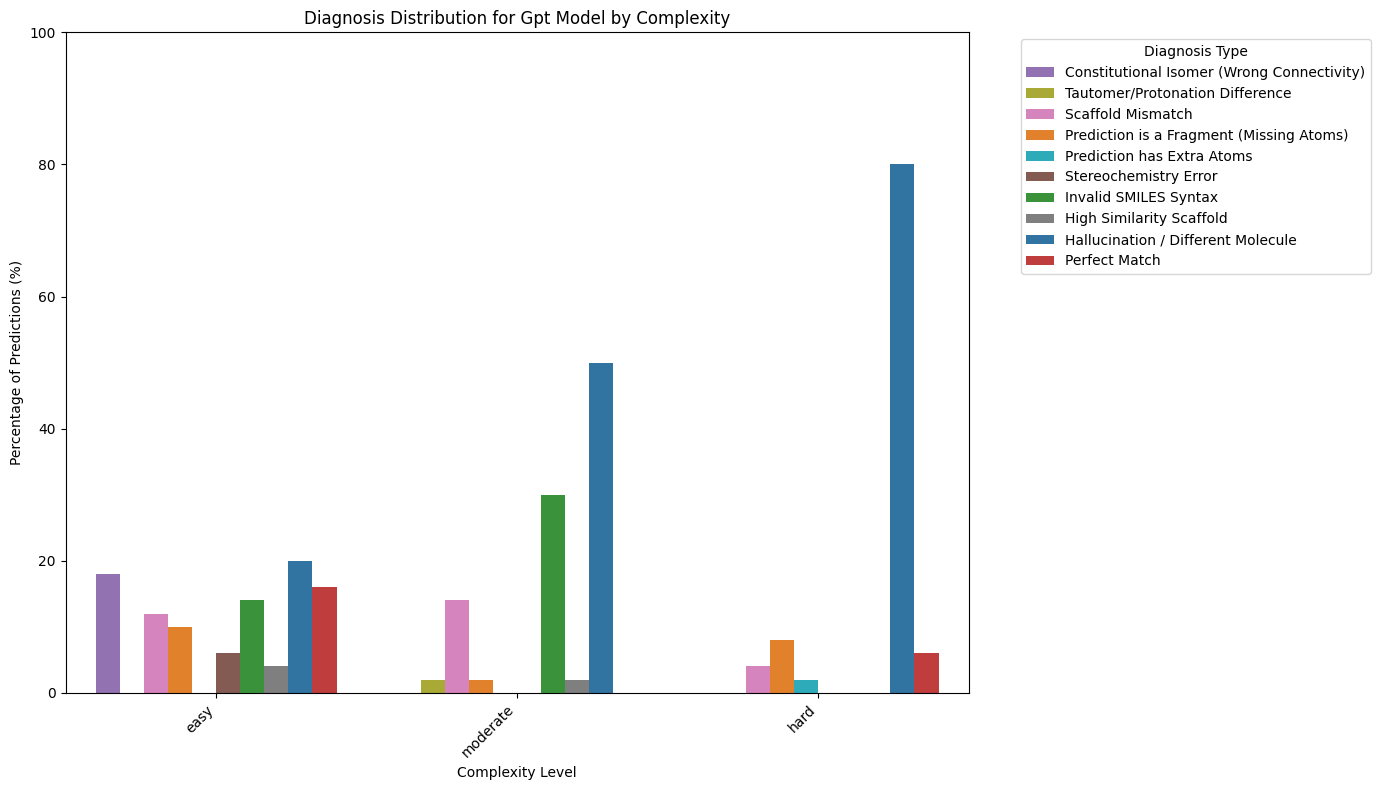

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df and diagnosis_color_map are available from previous cells

print("\n--- Diagnosis Analysis per Model and Complexity ---")

complexity_levels = ['easy', 'moderate', 'hard']
models = merged_df['model'].unique()

for model_name in models:
    # Filter data for the current model
    df_model = merged_df[merged_df['model'] == model_name]

    # Calculate diagnosis counts for each complexity level within this model
    diagnosis_summary = df_model.groupby(['complexity', 'diagnose']).size().unstack(fill_value=0)

    # Convert counts to percentages
    diagnosis_summary_percentage = diagnosis_summary.apply(lambda x: x / x.sum() * 100, axis=1)

    if not diagnosis_summary.empty:
        # Prepare data for plotting (long format is often better for seaborn)
        plot_data = diagnosis_summary_percentage.stack().reset_index(name='percentage')
        plot_data.rename(columns={'level_1': 'diagnose'}, inplace=True)

        # Ensure complexity levels are ordered for consistent plotting
        plot_data['complexity'] = pd.Categorical(plot_data['complexity'], categories=complexity_levels, ordered=True)
        plot_data = plot_data.sort_values(by='complexity')

        plt.figure(figsize=(14, 8))
        sns.barplot(
            data=plot_data,
            x='complexity',
            y='percentage',
            hue='diagnose',
            palette=diagnosis_color_map,
            dodge=True
        )

        plt.title(f'Diagnosis Distribution for {model_name.capitalize()} Model by Complexity')
        plt.xlabel('Complexity Level')
        plt.ylabel('Percentage of Predictions (%)')
        plt.ylim(0, 100)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Diagnosis Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No diagnosis data for {model_name} model.")